In [1]:
%matplotlib inline

import numpy as np
import torch
import argparse
from models.vqvae_3stage import VQVAE3Stage
from models.vqvae_2stage import VQVAE2Stage
from utils.dsp import mel2mcc, mcc2mel
from utils.synthesizer import PWGSynthesizer
from utils.common_utils import get_list_of_files
import librosa
import json
from os.path import join, exists
import matplotlib.pyplot as plt
from adjustText import adjust_text

import IPython.display as ipd
from sklearn.decomposition import PCA
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [2]:
config_file_path = "cfg/notebook_configs_jvs_24k.json"
with open(config_file_path) as f:
    configs = json.load(f)

model_configs = configs["model_configs"]
synthesizer_configs = configs["validation_configs"]["synthesizer_configs"]
model_checkpoint = "checkpoints/storage/20200814_1726_vqvae_3stage_jvs/weight_latest.pt"
# model_checkpoint = "checkpoints/storage/20200815_1314_vqvae_3stage_jvs/weight_latest.pt"
# model_checkpoint = "checkpoints/storage/20200817_1231_vqvae_3stage_jvs/weight_latest.pt"
# model_checkpoint = "checkpoints/storage/20200818_0152_vqvae_2stage_joint_jvs/weight_latest.pt"
model_configs["n_speaker"] = 100
model = VQVAE2Stage(**model_configs).eval().cuda()
model.load_state_dict(torch.load(model_checkpoint))
synthesizer = PWGSynthesizer(**synthesizer_configs, device='cuda')


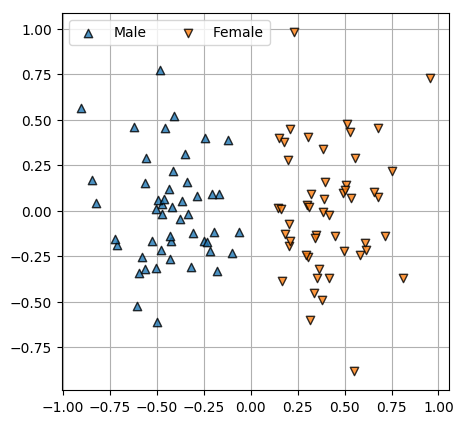

In [3]:
test_file = "/home/messier/PycharmProjects/data/jvs_ver1/mel24k/jvs001/VOICEACTRESS100_007.npy"

# Load speaker label
with open("jvs_speaker_label.json", "r") as f:
    speaker_label = json.load(f)

# Load F0 stats
with open("jvs_f0_stats.json", "r") as f:
    jvs_f0_stats = json.load(f)

source_speaker = test_file.split("/")[-2]
# source_speaker = "jvs002"
src_f0_mean, src_f0_scale = jvs_f0_stats[source_speaker]
emb = model.get_speaker_emb().cpu().numpy()
pca_emb = PCA(n_components=8, svd_solver='arpack')
emb_pca = pca_emb.fit_transform(emb)

src_emb = emb[speaker_label[source_speaker]]
src_emb_pca = emb_pca[speaker_label[source_speaker]]

with open("jvs_speaker_info.json", "r") as f:
    speaker_info = json.load(f)
male_speaker = [k for k in speaker_info.keys() if speaker_info[k]["gender"] == "M"]
female_speaker = [k for k in speaker_info.keys() if speaker_info[k]["gender"] == "F"]
male_speaker_id = [speaker_label[k] for k in male_speaker]
female_speaker_id = [speaker_label[k] for k in female_speaker]
# plt.figure(figsize=(5, 5), dpi=100)
# plt.bar(np.arange(16), pca_emb.explained_variance_ratio_, zorder=3, edgecolor="black")
# plt.grid(zorder=-1)
# plt.title("PCA explained variance ratio")
plt.figure(figsize=(5, 5), dpi=100)
plt.scatter(emb_pca[male_speaker_id, 0], emb_pca[male_speaker_id, 1], zorder=4, 
            alpha=0.8, edgecolor='black', marker='^', label='Male')
plt.scatter(emb_pca[female_speaker_id, 0], emb_pca[female_speaker_id, 1],
            zorder=4, alpha=0.8, edgecolor='black', marker= 'v',label='Female')
plt.legend(ncol=2)
plt.grid(zorder=-1)



In [4]:
emb_pca_max = np.max(emb_pca, axis=0)
emb_pca_min = np.min(emb_pca, axis=0)
f0_mean_max = np.max([f0[0] for f0 in jvs_f0_stats.values()])
f0_mean_min = np.min([f0[0] for f0 in jvs_f0_stats.values()])
f0_scale_max = np.max([f0[1] for f0 in jvs_f0_stats.values()])
f0_scale_min = np.min([f0[1] for f0 in jvs_f0_stats.values()])

In [5]:
# Load source mel file
mel_src = torch.from_numpy(np.load(test_file)).float().unsqueeze(0)
mel_src = mel_src[:, :, :8*(mel_src.shape[-1] // 8)]
# Load source f0 file
f0_src = torch.from_numpy(np.load(test_file.replace("mel24k", "f0_24k"))).float()
vuv = torch.zeros(f0_src.shape)

mcc_src = mel2mcc(mel_src).cuda()

In [6]:
@interact(emb_dim_0=(emb_pca_min[0], emb_pca_max[0], 0.1), 
          emb_dim_1=(emb_pca_min[1], emb_pca_max[1], 0.1),
          emb_dim_2=(emb_pca_min[2], emb_pca_max[2], 0.1), 
          emb_dim_3=(emb_pca_min[3], emb_pca_max[3], 0.1), 
          emb_dim_4=(emb_pca_min[4], emb_pca_max[4], 0.1), 
          f0_mean=(f0_mean_min, f0_mean_max, 0.1), 
          f0_scale=(f0_scale_min, f0_scale_max, 0.01))
def voice_conversion(emb_dim_0=src_emb_pca[0], emb_dim_1=src_emb_pca[1], emb_dim_2=src_emb_pca[2],
                     emb_dim_3=src_emb_pca[3], emb_dim_4=src_emb_pca[4],
                     f0_mean=src_f0_mean, 
                     f0_scale=src_f0_scale):
    tar_emb_pca = src_emb_pca
    tar_emb_pca[:5] = np.array([emb_dim_0, emb_dim_1, emb_dim_2, emb_dim_3, emb_dim_4])
    vuv[f0_src > 0] = 1.0
    f0_tar = vuv*((f0_src - src_f0_mean) * f0_scale / src_f0_scale + f0_mean)
    f0_tar = f0_tar[(None,)*2]
    f0_tar = f0_tar[:, :, :8*(mel_src.shape[-1] // 8)].cuda()
    tar_emb = pca_emb.inverse_transform(tar_emb_pca)
    tar_emb = torch.from_numpy(tar_emb).float().unsqueeze(0)
    x = torch.cat([mcc_src, f0_tar], dim=1)
    # print(tar_emb.shape)
    with torch.no_grad():
        global mel_hat
        mel_hat = model.inference([x, tar_emb.cuda()], input_speaker_emb=True)
    mel_hat = mel_hat.squeeze().cpu().numpy()
    plt.figure(dpi=100, figsize=(12, 3))
    plt.imshow(mel_hat, aspect='auto', origin='lower', cmap='inferno', vmin=-4.5, vmax=1)
    plt.colorbar()
    plt.title("Converted")
    plt.show()
#     plt.plot(mel_hat[:, 150])
#     plt.ylim([-4, 1])
#     plt.show()

interactive(children=(FloatSlider(value=-0.3333854377269745, description='emb_dim_0', max=0.9576676487922668, …

In [8]:
ipd.Audio(synthesizer.synthesize(mel_hat), rate=24000)